<a href="https://colab.research.google.com/github/Abhithray/Cybersec-Portfolio/blob/main/hybrid%20intrusion%20detection%20prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# section 1
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import io
import requests

# Load training data
# Assuming you have uploaded the CSV file to your Colab environment
url = 'https://drive.google.com/uc?id=1O_V__o-kN8vm66mJe7aJIdtVpvu0tL8b&export=download' #Updated with file path from Google Colab
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')))

# Continue with the rest of your code

In [ ]:
# section 2
# Drop non-informative features
# Check if columns exist before dropping
columns_to_drop = ['id', 'srcip', 'sport', 'dstip', 'dsport', 'proto']
existing_columns = df.columns
columns_to_drop = [col for col in columns_to_drop if col in existing_columns]

df.drop(columns_to_drop, axis=1, inplace=True)

# Encode categorical variables
cat_cols = df.select_dtypes(include=['object']).columns
label_encoders = {col: LabelEncoder().fit(df[col]) for col in cat_cols}
for col, le in label_encoders.items():
    df[col] = le.transform(df[col])

# Split features and labels
X = df.drop('label', axis=1)
y = df['label']

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Combine X and y to balance classes
df_train = pd.concat([pd.DataFrame(X_train), pd.Series(y_train, name='label')], axis=1)

# Separate majority and minority classes
df_anomaly = df_train[df_train.label == 1]
df_normal = df_train[df_train.label == 0]

# Import resample from sklearn.utils
from sklearn.utils import resample

# Upsample minority (normal traffic)
df_normal_upsampled = resample(
    df_normal,
    replace=True,
    n_samples=len(df_anomaly),
    random_state=42
)

# Combine balanced dataset
df_balanced = pd.concat([df_anomaly, df_normal_upsampled])

# Reset index and separate X, y
X_train = df_balanced.drop("label", axis=1).reset_index(drop=True)
y_train = df_balanced["label"].reset_index(drop=True)

In [ ]:
#section 3
import numpy as np
import random

# Simplified grid-like environment using tabular state encoding
class DRLEnvironment:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.num_states = data.shape[0] # num_states is the number of rows in the data
        self.num_actions = 2  # 0: Normal, 1: Anomaly
        self.reset()

    def reset(self):
        self.index = random.randint(0, self.num_states - 1) # generate a random index between 0 and num_states - 1
        # Access data and labels using .iloc[] for integer-location based indexing
        return self.data.iloc[self.index], self.labels.iloc[self.index]

    def step(self, action):
        true_label = self.labels.iloc[self.index] # Access label using .iloc[]
        if action == 1 and true_label == 1:
          reward = +1.0     # True Positive
        elif action == 0 and true_label == 0:
          reward = +1.0  # True Negative
        elif action == 1 and true_label == 0:
          reward = -1.5    # False Positive
        elif action == 0 and true_label == 1:
          reward = -2.0    # False Negative
        else:
          reward = -0.5

        done = True
        return self.reset()[0], reward, done

env = DRLEnvironment(X_train, y_train)

In [ ]:
!pip install qiskit
!pip install qiskit[visualization]

In [ ]:
!pip install qiskit qiskit-aer --quiet


In [ ]:
from qiskit_aer import Aer


In [ ]:
#Section 4
from qiskit_aer import Aer
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Statevector

def qaoa_action_selector(q_values):
    # Apply softmax
    def softmax(q):
        e = np.exp(q - np.max(q))
        return e / e.sum()

    q_values = softmax(q_values)
    num_actions = len(q_values)
    qc = QuantumCircuit(num_actions)

    # Initialize superposition
    for q in range(num_actions):
        qc.h(q)

    # Apply cost Hamiltonian
    for i, qv in enumerate(q_values):
        qc.rz(-qv, i)

    # Apply mixer Hamiltonian
    for i in range(num_actions):
        qc.rx(np.pi / 2, i)

    # Simulate circuit
    backend = Aer.get_backend('statevector_simulator')
    state = Statevector.from_instruction(qc)
    probs = state.probabilities_dict()

    # Decode result into integer actions
    decoded_probs = {int(k, 2): v for k, v in probs.items()}
    action = max(decoded_probs, key=decoded_probs.get)
    print("QAOA probs:", decoded_probs)

    return action % num_actions

In [ ]:
# section 5
import numpy as np
import random

# Reset index after train-test split to avoid KeyErrors
X_train = pd.DataFrame(X_train).reset_index(drop=True)
y_train = pd.Series(y_train).reset_index(drop=True)

# Define environment class again (in case it wasn't updated)
class DRLEnvironment:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.num_states = data.shape[0]
        self.reset()

    def reset(self):
        self.index = random.randint(0, self.num_states - 1)
        return self.data.iloc[self.index], self.labels.iloc[self.index]

    def step(self, action):
        true_label = self.labels.iloc[self.index] # Access label using .iloc[]
        if action == 1 and true_label == 1:
          reward = +1.0     # True Positive
        elif action == 0 and true_label == 0:
          reward = +1.0   # True Negative
        elif action == 1 and true_label == 0:
          reward = -1.5     # False Positive
        elif action == 0 and true_label == 1:
          reward = -2.0     # False Negative
        else:
          reward = -0.5
        done = True
        return self.reset()[0], reward, done

# Initialize environment and Q-table
env = DRLEnvironment(X_train, y_train)
q_table = np.zeros((len(X_train), 2))  # 2 actions: 0 = normal, 1 = anomaly

# Hyperparameters
alpha = 0.1
gamma = 0.9
episodes = 7500

# Training loop
for ep in range(episodes):
    state_vec, true_label = env.reset()

    # Use the correct index from the environment
    state_index = env.index

    # Get Q-values for current state
    q_values = q_table[state_index]

    # Use QAOA to choose an action
    action = qaoa_action_selector(q_values)

    # Step in environment
    _, reward, _ = env.step(action)

    # Pick a next state randomly and update Q-table
    next_state_index = random.randint(0, len(X_train) - 1)
    print(f"Before Q-values[{state_index}]: {q_table[state_index]}")
    q_table[state_index, action] += alpha * (
    reward + gamma * np.max(q_table[next_state_index]) - q_table[state_index, action]
    )
    print(f"After Q-values[{state_index}]: {q_table[state_index]}")


    # Print status
if ep % 500 == 0:
    print(f"Episode {ep}, State Index: {state_index}, Action: {action}, Reward: {reward}")
    print(f"Q-values: {q_table[state_index]}")


Streaming output truncated to the last 5000 lines.
Before Q-values[29772]: [0. 0.]
After Q-values[29772]: [0.  0.1]
QAOA probs: {0: np.float64(0.06774944246438097), 1: np.float64(0.19253778823351728), 2: np.float64(0.19253778823351728), 3: np.float64(0.5471749810685838)}
Before Q-values[39316]: [0. 0.]
After Q-values[39316]: [ 0.   -0.15]
QAOA probs: {0: np.float64(0.06756725605953981), 1: np.float64(0.20930792812209842), 2: np.float64(0.17646781793688482), 3: np.float64(0.5466569978814766)}
Before Q-values[51922]: [ 0.   -0.15]
After Q-values[51922]: [ 0.    -0.285]
QAOA probs: {0: np.float64(0.06774944246438097), 1: np.float64(0.19253778823351728), 2: np.float64(0.19253778823351728), 3: np.float64(0.5471749810685838)}
Before Q-values[45859]: [0. 0.]
After Q-values[45859]: [ 0.   -0.15]
QAOA probs: {0: np.float64(0.06774944246438097), 1: np.float64(0.19253778823351728), 2: np.float64(0.19253778823351728), 3: np.float64(0.5471749810685838)}
Before Q-values[30112]: [0. 0.]
After Q-value

Streaming output truncated to the last 5000 lines.
QAOA probs: {0: np.float64(0.06770919781997455), 1: np.float64(0.20033152559957124), 2: np.float64(0.18489867816308625), 3: np.float64(0.5470605984173675)}
QAOA probs: {0: np.float64(0.06722693735796094), 1: np.float64(0.22135833584986986), 2: np.float64(0.16572652076790118), 3: np.float64(0.5456882060242674)}
QAOA probs: {0: np.float64(0.06632605609159002), 1: np.float64(0.24122629546713995), 2: np.float64(0.14933171974864584), 3: np.float64(0.5431159286926237)}
QAOA probs: {0: np.float64(0.06495393929859027), 1: np.float64(0.1334630466703756), 2: np.float64(0.2624068407343734), 3: np.float64(0.5391761732966605)}
QAOA probs: {0: np.float64(0.06725278072116346), 1: np.float64(0.16637402820696293), 2: np.float64(0.2206113605121024), 3: np.float64(0.5457618305597707)}
QAOA probs: {0: np.float64(0.06731869244584285), 1: np.float64(0.16811216443921723), 2: np.float64(0.21861957977778726), 3: np.float64(0.5459495633371522)}
QAOA probs: {0: 

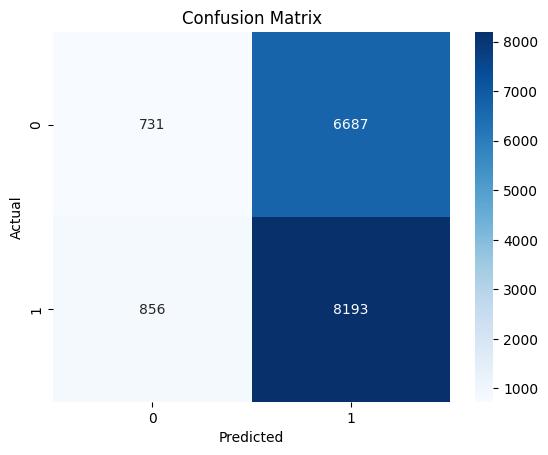

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = []
for i in range(len(X_test)):
    state_vec = X_test[i]
    q_values = np.random.rand(2)  # Simulate learned Q-values for demo
    explore_chance = 0.2  # 20% of the time, choose randomly
    if random.random() < explore_chance:
        action = random.choice([0, 1])
    else:
        action = qaoa_action_selector(q_values)

    # Append prediction outside the if-else block
    y_pred.append(action)

from collections import Counter
print("Predicted class distribution:", Counter(y_pred))

print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()